## Import libraries

In [40]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv("Telco_customer_churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Pre-processing

#### Inspect column type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

#### Set Numeric Column Type

In [4]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

#### Drop columns

After discussion, we dropped location data and columns of similar nature and only retain Churn Value as the predictor.

In [5]:
df = df.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Reason'], axis=1)

#### Check Null Value

There are 11 null values in total charges. We decide to remove them directly.

In [6]:
df.isnull().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
CLTV                  0
dtype: int64

In [7]:
df = df.dropna()
df.isnull().sum()

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64

#### Feature Engineering

Instead of total charges or monthly charges, we decide to use charges per month as the only predictor for charges.

In [8]:
df['ChargesPerMonth'] = df['Total Charges'] / df['Tenure Months']

In [9]:
df = df.drop(['Total Charges', 'Monthly Charges'], axis=1)

#### One-hot encoding

In [10]:
df = pd.get_dummies(df, drop_first=True)
df

,Tenure Months,Churn Value,CLTV,ChargesPerMonth,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,2,1,3239,54.075000,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
1,2,1,2701,75.825000,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,True,False
2,8,1,5372,102.562500,False,False,False,True,True,False,...,False,True,False,True,False,False,True,False,True,False
3,28,1,5003,108.787500,False,False,True,True,True,False,...,False,True,False,True,False,False,True,False,True,False
4,49,1,5340,102.781633,True,False,False,True,True,False,...,False,True,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,72,0,5306,19.713889,False,False,False,False,True,False,...,True,False,True,False,False,True,True,False,False,False
7039,24,0,2140,82.937500,True,False,True,True,True,False,...,False,True,False,True,True,False,True,False,False,True
7040,72,0,5560,102.262500,False,False,True,True,True,False,...,False,True,False,True,True,False,True,True,False,False
7041,11,0,2793,31.495455,False,False,True,True,False,True,...,False,False,False,False,False,False,True,False,True,False


#### Data splitting

We used stratified strategy considering this is an imbalanced dataset.

In [11]:
y = df['Churn Value']
X = df.drop('Churn Value',axis=1)

# Stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

Double check that the stratified train set makes sense.

In [12]:
## check if y_train contains 2 classes

from collections import Counter

print(Counter(y_train))

Counter({0: 3614, 1: 1308})


#### Apply SMOTE on training data

Apply Smote on training data only helps prevent leaks to test data.

In [13]:
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Apply Tomek Links on training data

In [14]:
#tomek_links = TomekLinks()
#X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train_smote, y_train_smote)

In [15]:
# Inspect the resampled data
#df_smote = pd.concat([pd.DataFrame(X_train_resampled, columns=X.columns), pd.DataFrame(y_train_resampled, columns=['Churn Value'])], axis=1)
#df_smote

#### Standardize the data

In [16]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

### Train and cross-validate

In [13]:
# Define l1 and l2 regression models
log_reg_ridge = LogisticRegression(penalty='l2', random_state=42, solver='liblinear')
log_reg_lasso = LogisticRegression(penalty='l1', random_state=42, solver='saga')

In [14]:
# Using pipelines for cross-validation later
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbalanced_Pipeline
# Create pipelines with SMOTETomek (resampling and scaling before classification)
ridge_pipeline = imbalanced_Pipeline([('scaler', StandardScaler()),
                                      ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),                                      
                                      ('log_reg', log_reg_ridge)])

lasso_pipeline = imbalanced_Pipeline([('scaler', StandardScaler()),
                                    ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),
                                      ('log_reg', log_reg_lasso)])
print(ridge_pipeline.named_steps)

{'scaler': StandardScaler(), 'smote': SMOTETomek(random_state=42), 'log_reg': LogisticRegression(random_state=42, solver='liblinear')}


In [15]:
# Define grid search range
# In here, I tried a few different ranges and discovered that the following ranges work best for AUC.

param_grid_ridge = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}
# param_grid_lasso = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
# param_grid_ridge = {'logisticregression__C': [0.005, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
param_grid_lasso = {'log_reg__C': [0.005, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [16]:
# Grid search for Ridge (L2)
ridge_search = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='accuracy')
ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTETomek(random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [17]:
# Grid search for LASSO (L1)
lasso_search = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='accuracy')
lasso_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTETomek(random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'log_reg__C': [0.005, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4,
                                        0.5, 0.6, 0.7, 0.8, 0.9]},
             scoring='accuracy')

In [18]:
# Best parameters and scores
print("Best Ridge (L2) Params:", ridge_search.best_params_)
print("Best Ridge (L2) CV Score:", ridge_search.best_score_)

print("Best LASSO (L1) Params:", lasso_search.best_params_)
print("Best LASSO (L1) CV Score:", lasso_search.best_score_)

Best Ridge (L2) Params: {'log_reg__C': 1}
Best Ridge (L2) CV Score: 0.7586389335974578
Best LASSO (L1) Params: {'log_reg__C': 0.3}
Best LASSO (L1) CV Score: 0.7590454376624985


The best parameter for Ridge is 0.01.
The best parameter for LASSO is 0.075.

#### Evaluate on the test set

Evaluating the best models on the test set, the accuracy is only 0.6853 and 0.6161 for Ridge and LASSO respectively.

In [19]:
# Evaluate on test set with best models
ridge_best_pipeline = ridge_search.best_estimator_
lasso_best_pipeline = lasso_search.best_estimator_

ridge_test_score = ridge_best_pipeline.score(X_test, y_test)
lasso_test_score = lasso_best_pipeline.score(X_test, y_test)

print("Ridge Test Score:", ridge_test_score)
print("LASSO Test Score:", lasso_test_score)

Ridge Test Score: 0.7744075829383886
LASSO Test Score: 0.7753554502369668


In [20]:
# Predict probabilities for the test set
ridge_probs = ridge_best_pipeline.predict_proba(X_test)[:, 1]
lasso_probs = lasso_best_pipeline.predict_proba(X_test)[:, 1]

In [21]:
# Predict classes for the test set
ridge_preds = ridge_best_pipeline.predict(X_test)
lasso_preds = lasso_best_pipeline.predict(X_test)

In [22]:
# Calculate metrics for Ridge (L2)
ridge_accuracy = accuracy_score(y_test, ridge_preds)
ridge_recall = recall_score(y_test, ridge_preds)
ridge_precision = precision_score(y_test, ridge_preds)
ridge_auc = roc_auc_score(y_test, ridge_probs)

In [23]:
# Calculate metrics for LASSO (L1)
lasso_accuracy = accuracy_score(y_test, lasso_preds)
lasso_recall = recall_score(y_test, lasso_preds)
lasso_precision = precision_score(y_test, lasso_preds)
lasso_auc = roc_auc_score(y_test, lasso_probs)

In [24]:
# Print metrics
print("Ridge (L2) - Accuracy:", ridge_accuracy)
print("Ridge (L2) - Recall:", ridge_recall)
print("Ridge (L2) - Precision:", ridge_precision)
print("Ridge (L2) - AUC:", ridge_auc)

print("LASSO (L1) - Accuracy:", lasso_accuracy)
print("LASSO (L1) - Recall:", lasso_recall)
print("LASSO (L1) - Precision:", lasso_precision)
print("LASSO (L1) - AUC:", lasso_auc)

Ridge (L2) - Accuracy: 0.7744075829383886
Ridge (L2) - Recall: 0.7878787878787878
Ridge (L2) - Precision: 0.5531914893617021
Ridge (L2) - AUC: 0.8617473869059333
LASSO (L1) - Accuracy: 0.7753554502369668
LASSO (L1) - Recall: 0.7896613190730838
LASSO (L1) - Precision: 0.5544430538172715
LASSO (L1) - AUC: 0.8618060757961262


- AUC: Ridge performs better than LASSO
- Accuracy: Ridge performs better than LASSO
- Recall: Ridge performs better than LASSO
- Precision: Ridge performs better than LASSO

In particular, Ridge has a very high recall, which is what we would like to see.

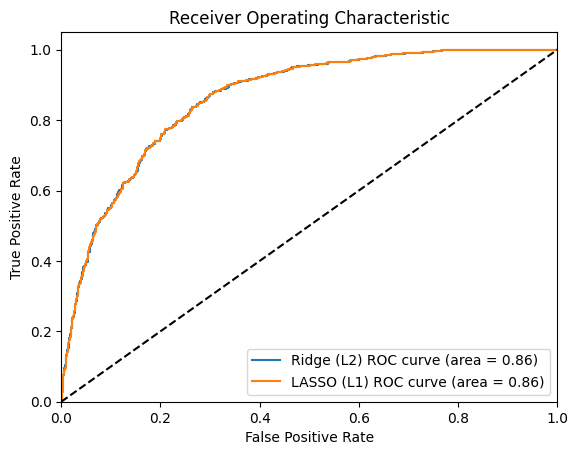

In [25]:
# Plot ROC curves
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, ridge_probs)
lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_probs)

plt.figure()
plt.plot(ridge_fpr, ridge_tpr, label='Ridge (L2) ROC curve (area = %0.2f)' % ridge_auc)
plt.plot(lasso_fpr, lasso_tpr, label='LASSO (L1) ROC curve (area = %0.2f)' % lasso_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Calibration Curve

In [26]:
# Compute calibration curve
ridge_frac_pos, ridge_mean_pred = calibration_curve(y_test, ridge_probs, n_bins=10)
lasso_frac_pos, lasso_mean_pred = calibration_curve(y_test, lasso_probs, n_bins=10)


Logistics regression is supposed to be calibrated natively, but this chart shows otherwise... There are a few reasons for it according to ChatGPT:

1. Imbalanced Data: If the dataset is imbalanced, it can affect the calibration. Ensure proper handling of class imbalance.
2. Regularization: Strong regularization (L1 or L2) can impact the calibration, especially if not tuned properly.
3. Feature Scaling: Ensure that all preprocessing steps, including scaling, are correctly applied.
4. Model Complexity: Logistic regression may not capture complex patterns if the data is non-linear or has complex interactions.
5. Data Quality: Check for noise or outliers in the data that could affect predictions.

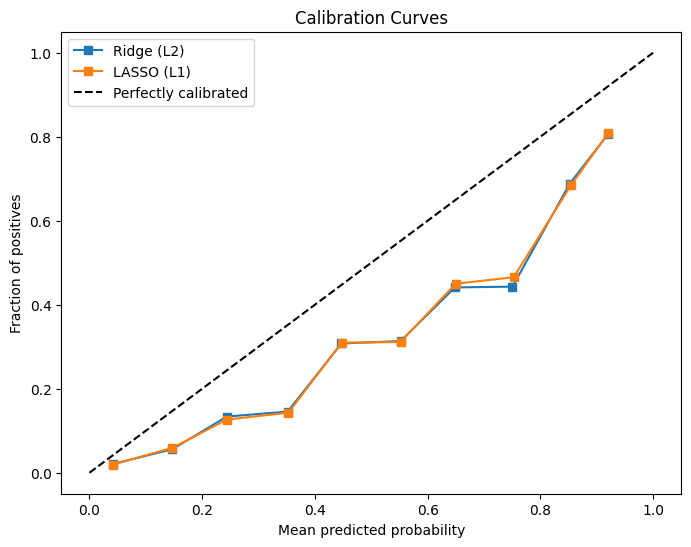

In [27]:
# Plot calibration curves
plt.figure(figsize=(8, 6))
plt.plot(ridge_mean_pred, ridge_frac_pos, "s-", label='Ridge (L2)')
plt.plot(lasso_mean_pred, lasso_frac_pos, "s-", label='LASSO (L1)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend(loc="upper left")
plt.show()

### Understand feature importance

Axes(0.125,0.11;0.775x0.77)


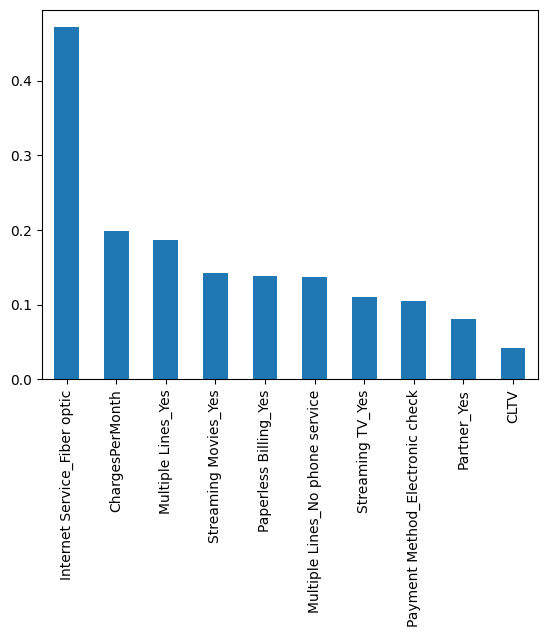

In [28]:
# Get the best LASSO and Ridge models from the grid search
best_ridge_model = ridge_search.best_estimator_.named_steps['log_reg']
best_lasso_model = lasso_search.best_estimator_.named_steps['log_reg']

# Get the coefficients
ridge_coefficients = best_ridge_model.coef_
lasso_coefficients = best_lasso_model.coef_

# Get weights of the first 10 variables for Ridge
weights_ridge = pd.Series(best_ridge_model.coef_[0],
                 index=X.columns.values)
print (weights_ridge.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


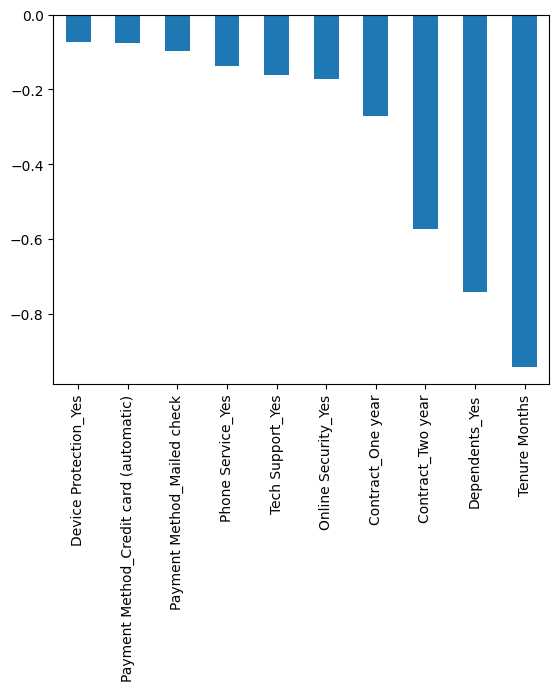

In [30]:
print(weights_ridge.sort_values(ascending = False)[-10:].plot(kind='bar'))


Axes(0.125,0.11;0.775x0.77)


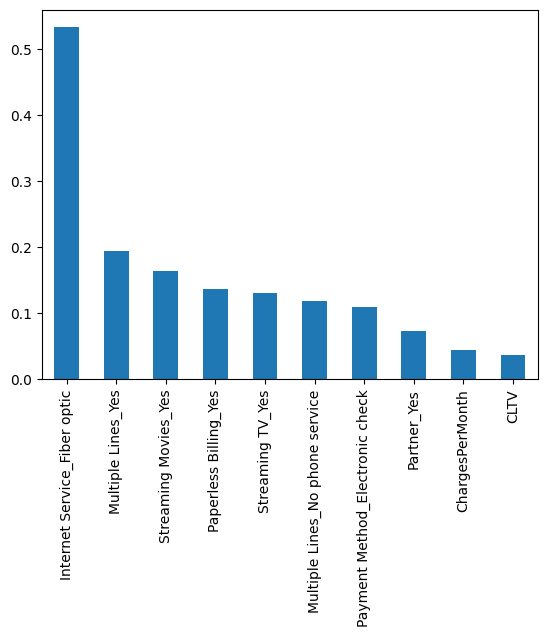

In [31]:
# Get weights of the first 10 variables for LASSO
weights_lasso = pd.Series(best_lasso_model.coef_[0],
                 index=X.columns.values)
print (weights_lasso.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


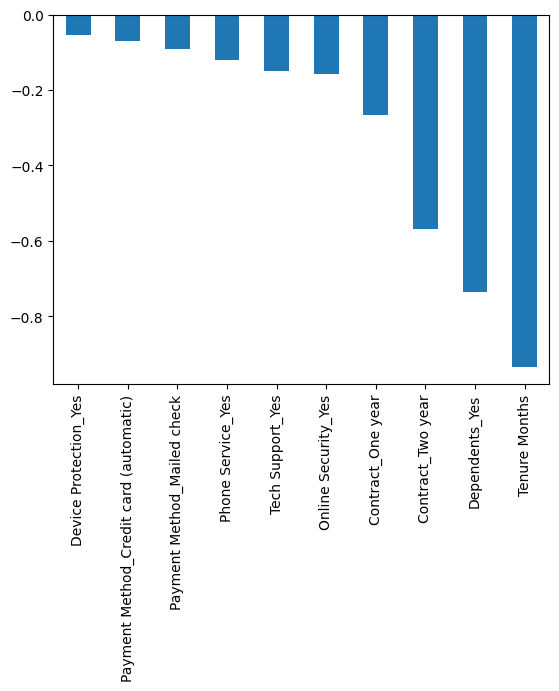

In [32]:
print(weights_lasso.sort_values(ascending = False)[-10:].plot(kind='bar'))


#### Attempt to Calibrate... unsuccessfully

In [33]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_ridge = CalibratedClassifierCV(ridge_best_pipeline, method='sigmoid', cv='prefit')
calibrated_ridge.fit(X_train, y_train)

calibrated_lasso = CalibratedClassifierCV(lasso_best_pipeline, method='sigmoid', cv='prefit')
calibrated_lasso.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('smote',
                                                  SMOTETomek(random_state=42)),
                                                 ('log_reg',
                                                  LogisticRegression(C=0.3,
                                                                     penalty='l1',
                                                                     random_state=42,
                                                                     solver='saga'))]))

In [34]:
# Predict probabilities for AUC and ROC
ridge_probs_calibrated = calibrated_ridge.predict_proba(X_test)[:, 1]
lasso_probs_calibrated = calibrated_lasso.predict_proba(X_test)[:, 1]

# Predict classes for the test set
ridge_preds_calibrated = calibrated_ridge.predict(X_test)
lasso_preds_calibrated = calibrated_lasso.predict(X_test)

In [35]:
# Calculate metrics for calibrated Ridge (L2)
ridge_accuracy_calibrated = accuracy_score(y_test, ridge_preds_calibrated)
ridge_precision_calibrated = precision_score(y_test, ridge_preds_calibrated)
ridge_recall_calibrated = recall_score(y_test, ridge_preds_calibrated)
ridge_auc_calibrated = roc_auc_score(y_test, ridge_probs_calibrated)

# Calculate metrics for calibrated LASSO (L1)
lasso_accuracy_calibrated = accuracy_score(y_test, lasso_preds_calibrated)
lasso_precision_calibrated = precision_score(y_test, lasso_preds_calibrated)
lasso_recall_calibrated = recall_score(y_test, lasso_preds_calibrated)
lasso_auc_calibrated = roc_auc_score(y_test, lasso_probs_calibrated)

In [36]:
# Print metrics
print("Calibrated Ridge (L2) - Accuracy:", ridge_accuracy_calibrated)
print("Calibrated Ridge (L2) - Precision:", ridge_precision_calibrated)
print("Calibrated Ridge (L2) - Recall:", ridge_recall_calibrated)
print("Calibrated Ridge (L2) - AUC:", ridge_auc_calibrated)

print("Calibrated LASSO (L1) - Accuracy:", lasso_accuracy_calibrated)
print("Calibrated LASSO (L1) - Precision:", lasso_precision_calibrated)
print("Calibrated LASSO (L1) - Recall:", lasso_recall_calibrated)
print("Calibrated LASSO (L1) - AUC:", lasso_auc_calibrated)

Calibrated Ridge (L2) - Accuracy: 0.8109004739336493
Calibrated Ridge (L2) - Precision: 0.68
Calibrated Ridge (L2) - Recall: 0.5454545454545454
Calibrated Ridge (L2) - AUC: 0.8617473869059333
Calibrated LASSO (L1) - Accuracy: 0.8099526066350711
Calibrated LASSO (L1) - Precision: 0.6769911504424779
Calibrated LASSO (L1) - Recall: 0.5454545454545454
Calibrated LASSO (L1) - AUC: 0.8618060757961262


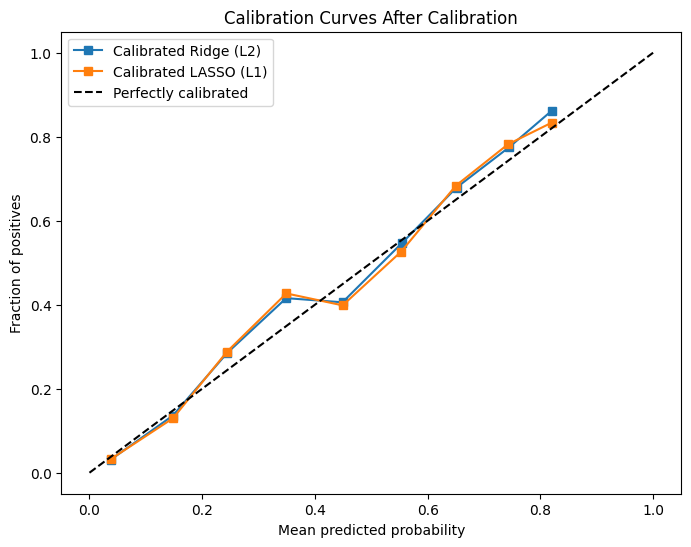

In [37]:
# Compute and plot calibration curves
ridge_frac_pos_calibrated, ridge_mean_pred_calibrated = calibration_curve(y_test, ridge_probs_calibrated, n_bins=10)
lasso_frac_pos_calibrated, lasso_mean_pred_calibrated = calibration_curve(y_test, lasso_probs_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(ridge_mean_pred_calibrated, ridge_frac_pos_calibrated, "s-", label='Calibrated Ridge (L2)')
plt.plot(lasso_mean_pred_calibrated, lasso_frac_pos_calibrated, "s-", label='Calibrated LASSO (L1)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves After Calibration')
plt.legend(loc="upper left")
plt.show()

##RANDOM FOREST

Using OPTUNA - to obtain best hyperparameters

In [38]:
from imblearn import pipeline as imbalanced_pipeline
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import optuna

# Define the Optuna objective function for tuning
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # ImbalancedPipeline with SMOTETomek, scaling, and RandomForestClassifier
    model_pipeline = imbalanced_pipeline.Pipeline([
       ('scaler', StandardScaler()),
        ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),        # Standard scaling
        ('classifier', RandomForestClassifier(  # Random forest with hyperparameters
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        ))
    ])

    # Cross-validation to evaluate model performance
    score = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Run the Optuna study to optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)

[I 2024-11-09 10:01:54,489] A new study created in memory with name: no-name-04409801-bc91-498c-9ea9-7aa6b08f5628
[I 2024-11-09 10:01:58,627] Trial 0 finished with value: 0.7911436116189315 and parameters: {'n_estimators': 357, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.7911436116189315.
[I 2024-11-09 10:02:03,889] Trial 1 finished with value: 0.7919558765971573 and parameters: {'n_estimators': 465, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 0.7919558765971573.
[I 2024-11-09 10:02:08,416] Trial 2 finished with value: 0.788907839261208 and parameters: {'n_estimators': 374, 'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 1 with value: 0.7919558765971573.
[I 2024-11-09 10:02:15,049] Trial 3 finished with value: 0.7885018306307378 and parameters: {'n_estimators': 439, 'max_depth': 34, 'min_samples_split

Best hyperparameters: {'n_estimators': 161, 'max_depth': 43, 'min_samples_split': 14, 'min_samples_leaf': 3, 'bootstrap': False}


Run the model with best parameters using Optuna

Accuracy: 0.7995
Precision: 0.6127
Recall: 0.6684
F1 Score: 0.6394
ROC AUC Score: 0.8604
classification report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1549
           1       0.61      0.67      0.64       561

    accuracy                           0.80      2110
   macro avg       0.74      0.76      0.75      2110
weighted avg       0.81      0.80      0.80      2110



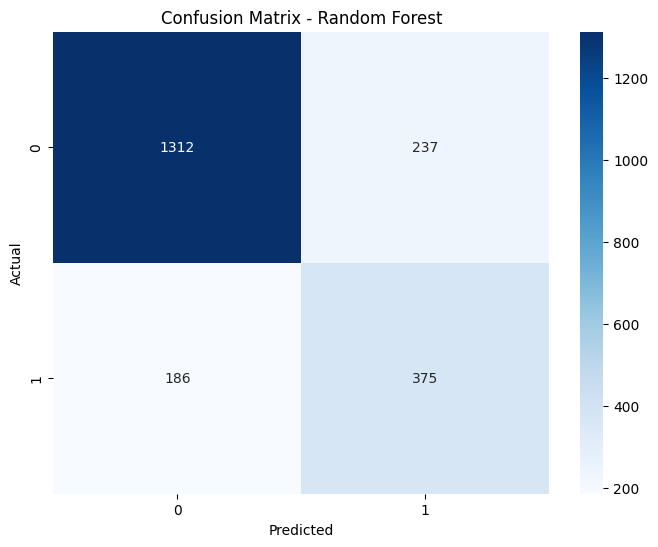

In [42]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
#Step 1: Train the final model using the best hyperparameters
best_params = study.best_params
final_model_pipeline = imbalanced_pipeline.Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        bootstrap=best_params['bootstrap'],
        random_state=42
    ))
])

# Fit the model on the training set
final_model_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = final_model_pipeline.predict(X_test)
y_pred_proba = final_model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model with various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("classification report")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()


RANDOM FOREST USING CROSS VALIDATION

In [43]:
RF_model = RandomForestClassifier(random_state=42)
RF_pipeline = imbalanced_Pipeline([('scaler', StandardScaler()),
                                      ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),                                      
                                      ('RF_Classifier', RF_model)])

print(RF_pipeline.named_steps)


{'scaler': StandardScaler(), 'smote': SMOTETomek(random_state=42), 'RF_Classifier': RandomForestClassifier(random_state=42)}


In [44]:
RF_param_grid = {
    'RF_Classifier__n_estimators': [50, 100, 150, 200],
    'RF_Classifier__max_depth': [10, 15, 20],
    'RF_Classifier__min_samples_split': [2, 5, 7],
    'RF_Classifier__min_samples_leaf': [2, 4, 6],
    'RF_Classifier__bootstrap': [True, False]
}

RF_search = GridSearchCV(RF_pipeline, param_grid=RF_param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
RF_search.fit(X_train, y_train)

best_params = RF_search.best_params_
best_model = RF_search.best_estimator_
y_pred_forest = best_model.predict(X_test)

print(best_params)
print(best_model)
print(accuracy_score(y_test, y_pred_forest))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'RF_Classifier__bootstrap': True, 'RF_Classifier__max_depth': 15, 'RF_Classifier__min_samples_leaf': 6, 'RF_Classifier__min_samples_split': 2, 'RF_Classifier__n_estimators': 200}
Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTETomek(random_state=42)),
                ('RF_Classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=6,
                                        n_estimators=200, random_state=42))])
0.7981042654028436


In [46]:
#Train the final CV model using the best hyperparameters
best_params = RF_search.best_params_
RF_final_model_pipeline = imbalanced_pipeline.Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(sampling_strategy='auto', random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['RF_Classifier__n_estimators'],
        max_depth=best_params['RF_Classifier__max_depth'],
        min_samples_split=best_params['RF_Classifier__min_samples_split'],
        min_samples_leaf=best_params['RF_Classifier__min_samples_leaf'],
        bootstrap=best_params['RF_Classifier__bootstrap'],
        random_state=42
    ))
])

# Fit the model on the entire training set
RF_final_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTETomek(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=6,
                                        n_estimators=200, random_state=42))])

##EVALUATE ON THE TEST SET

Accuracy: 0.7981
Precision: 0.6018
Recall: 0.7112
F1 Score: 0.6520
ROC AUC Score: 0.8617
classification report
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1549
           1       0.60      0.71      0.65       561

    accuracy                           0.80      2110
   macro avg       0.74      0.77      0.75      2110
weighted avg       0.81      0.80      0.80      2110



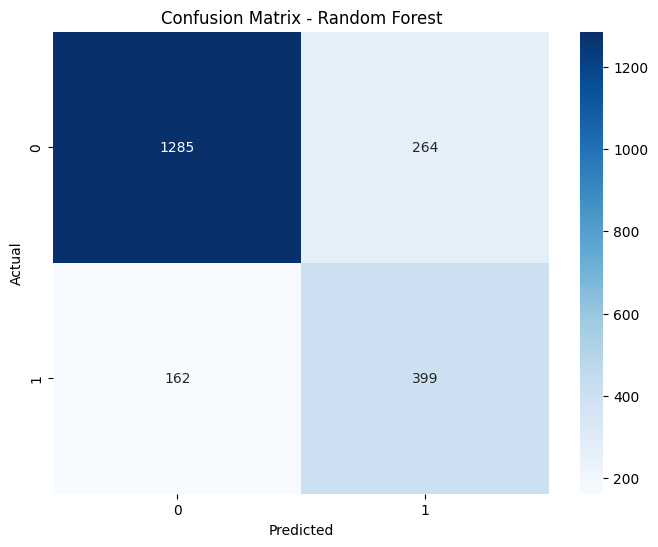

In [48]:

# Make predictions on the test set
y_pred = RF_final_model_pipeline.predict(X_test)
y_pred_proba = RF_final_model_pipeline.predict_proba(X_test)[:, 1]  # for ROC AUC

# Evaluate the model with various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("classification report")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

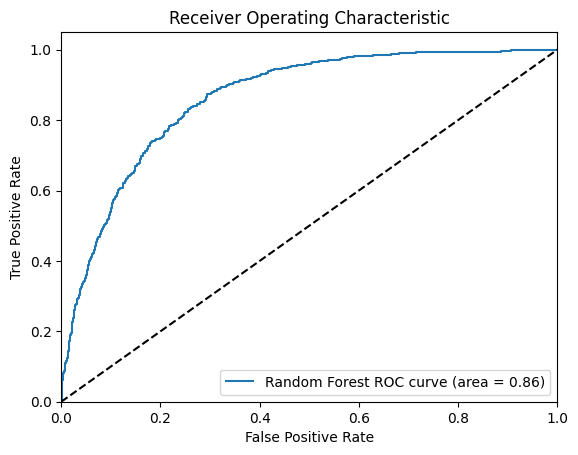

In [49]:
# Plot ROC curves
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred_proba)


plt.figure()
plt.plot(RF_fpr, RF_tpr, label='Random Forest ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

CALIBRATION CURVE - RANDOM FOREST

In [50]:
# Compute calibration curve
RF_frac_pos, RF_mean_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

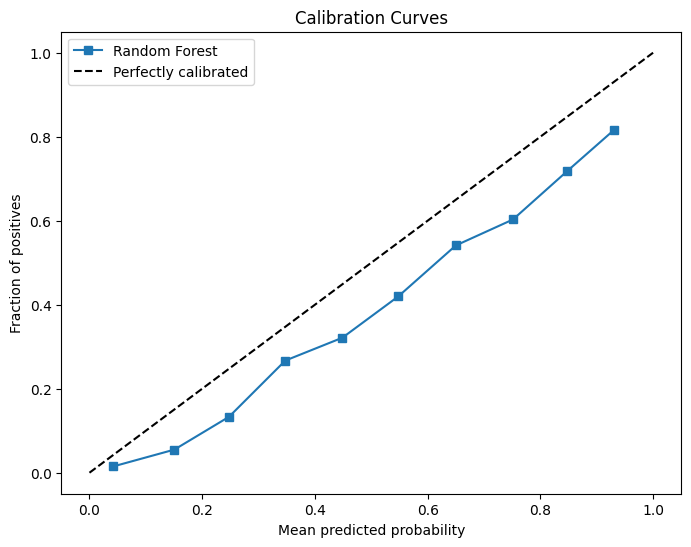

In [51]:
# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(RF_mean_pred, RF_frac_pos, "s-", label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend(loc="upper left")
plt.show()

In [52]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(RF_final_model_pipeline, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_train, y_train)


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('smote',
                                                  SMOTETomek(random_state=42)),
                                                 ('classifier',
                                                  RandomForestClassifier(max_depth=15,
                                                                         min_samples_leaf=6,
                                                                         n_estimators=200,
                                                                         random_state=42))]))

In [53]:
# Predict probabilities for AUC and ROC
rf_probs_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]

# Predict classes for the test set
rf_preds_calibrated = calibrated_rf.predict(X_test)

In [54]:
# Calculate metrics for calibrated Ridge (L2)
rf_accuracy_calibrated = accuracy_score(y_test, rf_preds_calibrated)
rf_precision_calibrated = precision_score(y_test, rf_preds_calibrated)
rf_recall_calibrated = recall_score(y_test, rf_preds_calibrated)
rf_auc_calibrated = roc_auc_score(y_test, rf_probs_calibrated)

In [55]:
# Print metrics
print("Calibrated RF - Accuracy:", rf_accuracy_calibrated)
print("Calibrated RF - Precision:", rf_precision_calibrated)
print("Calibrated RF Recall:", rf_recall_calibrated)
print("Calibrated RF - AUC:", rf_auc_calibrated)


Calibrated RF - Accuracy: 0.8080568720379147
Calibrated RF - Precision: 0.6529411764705882
Calibrated RF Recall: 0.5935828877005348
Calibrated RF - AUC: 0.8617232208923243


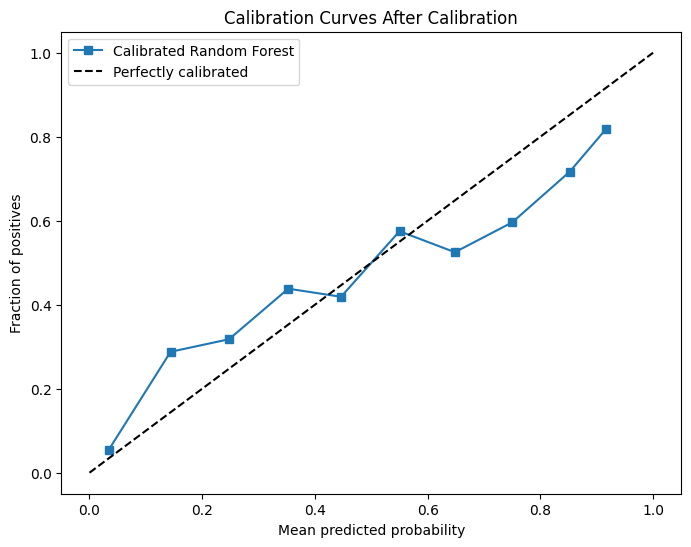

In [56]:
# Compute and plot calibration curves
rf_frac_pos_calibrated, rf_mean_pred_calibrated = calibration_curve(y_test, rf_probs_calibrated, n_bins=10)


plt.figure(figsize=(8, 6))
plt.plot(rf_mean_pred_calibrated, rf_frac_pos_calibrated, "s-", label='Calibrated Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves After Calibration')
plt.legend(loc="upper left")
plt.show()